# The Feynman-Kac formula
We illustrate below how the Feynman-Kac formula can be leveraged to solve the heat equation

$$
\left\{
\begin{aligned}
& \partial_t u(t, x) = \Delta u(t, x), \qquad & t \in (0, T], ~ x \in \mathbb R, \\
& u(0, x) = f(x), \qquad & x \in \mathbb R.
\end{aligned}
\right.
$$

This equation admits the exact solution

$$
u(t, x) = \frac{1}{\sqrt{4 \pi t}} \int_{-\infty}^{\infty} \exp \left( - \frac{(x-y)^2}{4t}\right) \, f(y) \, \mathrm d y,
$$

which is simply the convolution of the initial condition with the Green's function associated with the equation – the heat kernel.

By the Feynman-Kac formula for autonomous equations, the solution admits the representation

$$
u(t, x) = \mathbb E(f(X_t)), \qquad X_t = x + \int_0^t \sqrt{2} \, \mathrm d W_t,
$$

where $W$ is a Brownian motion.

Written more compactly,

$$
u(t, x) = \mathbb E(f(x + \sqrt{2} \, W_t)).
$$

We can therefore approximate $u(t, x)$ by Monte Carlo simulation. Here we do not even need to employ a numerical method for SDEs, because we need only to simulate Brownian motion.

In addition, since we can simulate Brownian motion exactly on discrete time points, our estimator of $u(t, x)$ will be unbiased.

We will take the initial condition to be the indicator function of the interval $[-1, 1]$, i.e. $f(x) = I_{[-1, 1]}(x)$. For this choice, the exact solution can be expressed more explicitly

$$
u(t, x) = \frac{1}{\sqrt{4 \pi t}} \int_{-1}^{1} \exp \left( - \frac{(x-y)^2}{4t}\right) \, \mathrm d y
=  \frac{1}{\sqrt{4 \pi t}} \int_{-1 + x}^{1 + x} \exp \left( - \frac{y^2}{4t}\right) \, \mathrm d y
=  \frac{1}{\sqrt{2 \pi}} \int_{(-1 + x) / \sqrt{2t}}^{(1 + x) / \sqrt{2t}} \exp \left( - \frac{y^2}{2}\right) \, \mathrm d y,
$$

which can be calculated from the CDF of a normally-distributed random variable.


In [2]:
# +
# Copyright (c) 2020 Urbain Vaes. All rights reserved.
#
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.

import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

matplotlib.rc('font', size=20)
matplotlib.rc('font', family='serif')
matplotlib.rc('figure', figsize=(13, 8))
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('lines', markersize=12)
matplotlib.rc('figure.subplot', hspace=.1)
matplotlib.rc('animation', html='html5')
# -


In [3]:
# f(x) = 1, for x in [-1, 1]
def initial_condition(x):       
    return (x >= -1)*(x <= 1)

def exact_solution(t, x):
    cdf = scipy.stats.norm.cdf
    return cdf((1 + x) / np.sqrt(2*t)) - cdf((-1 + x) / np.sqrt(2*t))


In [4]:
# Vector of times at which we will plot the exact and Monte Carlo solutions
T, N = 0, 100
t = np.linspace(0, 1, N + 1)
Δt = t[1] - t[0]

# Approximation by a Monte Carlo method

# We'll approximate the solution at a small number of space points
L, n, n_mc = 3, 400, 20
x_mc = np.linspace(-L, L, n_mc)

M = 10**3                       # number of Brownian paths
ws = np.vstack((np.zeros(M), np.random.randn(N, M)))
ws = np.sqrt(Δt) * np.cumsum(ws, axis=0)

# Array to store the results of the MC estimation
mc_estimator = np.zeros((n_mc, N + 1))
for i, xi in enumerate(x_mc):
    mc_estimator[i] = np.mean(initial_condition(xi + np.sqrt(2)*ws), axis=1)

x = np.linspace(-L, L, n)
fig, ax = plt.subplots()
ax.set_title("Solving the heat equation by a Monte Carlo method")
fig.subplots_adjust(left=.05, bottom=.1, right=.98, top=.98)


# The variables employed in plot_time need to be defined globally
line, line_mc, text = None, None, None

# Function to plot the exact and approximate solutions at the i-th time step
def plot_time(i):
    global line, line_mc, text

    if i == 0:
        ax.clear()
        line, = ax.plot(x, initial_condition(x), label="Exact solution")
        line_mc, = ax.plot(x_mc, mc_estimator[:, i], linestyle='', marker='.',
                           label="Monte Carlo solution")
        ax.legend()
        ax.set_xlabel('$x$')
        text = ax.text(.1, .9, r"$t = {:.4f}$".format(0),
                       fontsize=18, horizontalalignment='center',
                       verticalalignment='center', transform=ax.transAxes)
    else:
        line.set_ydata(exact_solution(t[i], x))
        line_mc.set_ydata(mc_estimator[:, i])
        text.set_text(r"$t = {:.4f}$".format(t[i]))

# Create animation
anim = animation.FuncAnimation(fig, plot_time, list(range(N + 1)),
                               init_func=lambda: None, repeat=True)

# For Jupyter notebook
plt.close(fig)
anim

# Za Python skript
# plt.show()

# Girsanov formula and importance sampling

Let us consider the following SDE with constant diffusion coefficient and deterministic initial condition:

$$
\mathrm{d} X_t = b(X_t) \, \mathrm{d} t + \sigma \, \mathrm{d} W_t, \qquad X_0 = x_0.
$$

The update formula of the Euler-Maruyama scheme for this equation is the following:

$$
X^{\Delta t}_{n+1} = X^{\Delta t}_n + b(X^{\Delta t}_n) \, \Delta t + \sigma \, \Delta W_n, \qquad X^{\Delta t}_0 = x_0, \qquad n = 0, \dotsc, N-1.
$$

This update formula defines a discrete-time stochastic process very similar to one we examined a few weeks ago, when we calculated the probability of ruin of a gambler by importance sampling.

Remember, in particular, that we derived an explicit expression for the PDF of $\{X^{\Delta t}_n\}_{n=1}^{N}$, viewed as a random variable in $\mathbb R^N$:

$$
f_X^N(x_1, \dotsc, x_N) =
\left|\frac{1}{\sqrt{2\pi\sigma^2\Delta t}}\right|^N \, \exp \left(-\frac{1}{2\sigma^2\Delta t} \sum_{k=0}^{N -1} \left|x_{k+1} - x_{k} - b(x_k) \Delta t \right|^2 \right).
$$

Let us now denote by $Y_t$ the exact solution to the equation without drift, i.e. with $b(\cdot) = 0$, by $Y^{\Delta t} = \{Y^{\Delta t}_n\}_{n=1}^{N}$ its Euler-Maruyama approximation, and by $f_{Y}^N$ the PDF of $Y^{\Delta t}$. A simple calculation shows the ratio of the densities, called the *likelihood ratio*, is given by:

$$
M_N(x_1, \dotsc, x_N) := \frac{f_Y^N(x_1, \dotsc, x_N)}{f_X^N(x_1, \dotsc, x_N)} = \exp \left(- \frac{1}{\sigma^2} \sum_{k=0}^{N -1} \left( b(x_k) \, (x_{k+1} - x_{k}) - \frac{1}{2} |b(x_k)|^2 \Delta t \right) \right).
$$

Since the right-hand side is strictly positive, we say in measure-theoretic terms that $f_Y^N$ (or, to be more precise, the measure associated to it) is *absolutely continuous* with respect to $f_X^N$. Since the reciprocal of the ratio is also positive, $f_X^N$ is also absolutely continuous with respect to $f_Y^N$: we say that the two measures are *equivalent*.

This implies in particular that we can use $f_X^N$ to compute expectations with respect to $f_Y^N$, and vice versa:

$$
\mathbb{E}_{Y^{\Delta t} \sim f_Y^N} [g(Y^{\Delta t})] = \mathbb{E}_{X^{\Delta t} \sim f_X^N} [M_N(X^{\Delta t}) \, g(X^{\Delta t})]. \tag{1}
$$

Here, $X^{\Delta t}$ and $Y^{\Delta t}$ are short notations for $(X^{\Delta t}_1, \dotsc, X^{\Delta t}_N)$ and $(Y^{\Delta t}_1, \dotsc, Y^{\Delta t}_N)$, respectively.

Now observe that if $X^{\Delta t}$ is obtained from the Euler-Maruyama scheme above, then we have

$$
M_N(X^{\Delta t}) = \exp \left(- \frac{1}{\sigma^2} \sum_{k=0}^{N -1} \left( \sigma \,b(X^{\Delta t}_k) \, \Delta W_k + \frac{1}{2} |b(X^{\Delta t}_k)|^2 \Delta t \right) \right).
$$

Denoting by $\hat X^{\Delta t} = \{\hat X^{\Delta t}\}_{t \in [0, 1]}$ the piecewise constant continuous-time interpolation of $\{X^{\Delta t}_n\}_{n=0}^N$, we can rewrite the previous equation as

$$
M_N(X^{\Delta t}) = \exp \left( - \frac{1}{\sigma} \int_0^T \,b(\hat X^{\Delta t}_t) \, \mathrm{d} W_t - \frac{1}{2 \sigma^2} \int_0^T |b(\hat X^{\Delta t}_t)|^2 \mathrm{d} t \right). \tag{2}
$$

The Girsanov theorem shows that some of these considerations can be extended to the continuous-time processes $X_t$ (with drift $b$) and $Y_t$ (without drift). Roughly speaking, the theorem states that we can pass to the limit in equation $(1)$, in the sense that

$$
\mathbb{E} [g(Y_t)] = \mathbb{E} [M(X_t) \, g(X_t)],
$$

where $M(t)$ admits the following expression

$$
M(X_t) = \exp \left( - \frac{1}{\sigma} \int_0^T \,b(X_t) \, \mathrm{d} W_t - \frac{1}{2 \sigma^2} \int_0^T |b(X_t)|^2 \mathrm{d} t \right),
$$

which is not surprising in view of $(2)$. Note that, in this equation, $W_t$ is the driving Brownian motion of the equation for $X_t$; it might be useful to see $W_t$ as a function of $X_t$. Note also that the laws of $X_t$ and $Y_t$ are measures over an infinite-dimensional space, so it does not make sense to consider their density with respect to a Lebesgue measure and to define $M(X_t)$ as a ratio, which is why Girsanov's theorem is useful.

Below we employ this result to estimate the probability that $Y_t = x_0 + \sigma W_t$ exceeds a certain threshold $K$ for some $t \in [0, T]$. This is the continuous counterpart of the gambler's ruin. By the [reflection principle](https://en.wikipedia.org/wiki/Reflection_principle_(Wiener_process)), this probability equals

$$
P := \mathbb{P} \left[\sup_{0 \leq t \leq T} Y_t \geq K \right]
  = 2 \mathbb{P} \left[ Y_T \geq K \right]
  = 2\left(1 -  \Phi\left(\frac{K-x_0}{\sigma \sqrt{T}}\right)\right),
$$

where $\Phi$ is the Gaussian CDF. For simplicity, we take $x_0 = 0$ i $T = 1$.


Exact value of the probability: 0.002700
95% confidence interval for P: [0.000381, 0.001619]
95% confidence interval for P: [0.001609, 0.001751]
95% confidence interval for P: [0.001124, 0.002876]
95% confidence interval for P: [0.002150, 0.002304]


95% confidence interval for P: [0.002176, 0.004424]
95% confidence interval for P: [0.002385, 0.002574]


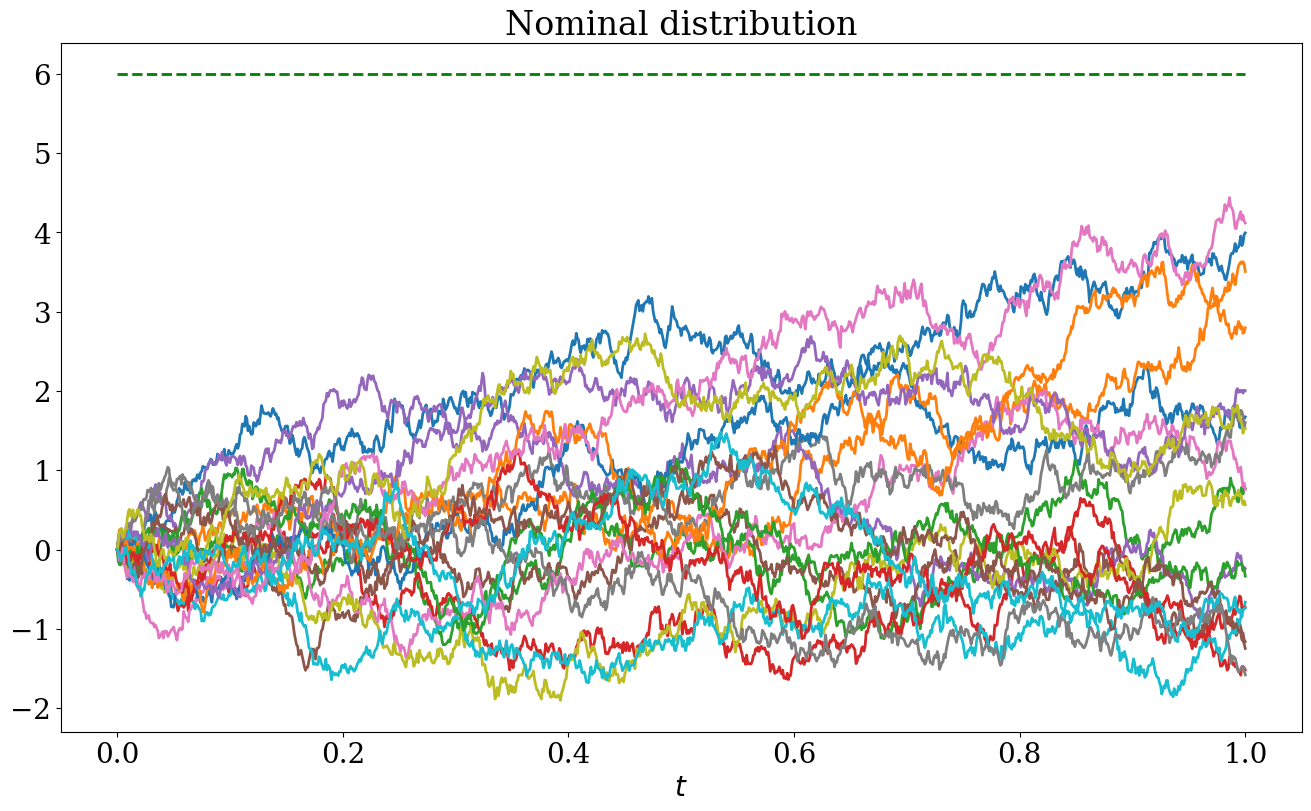

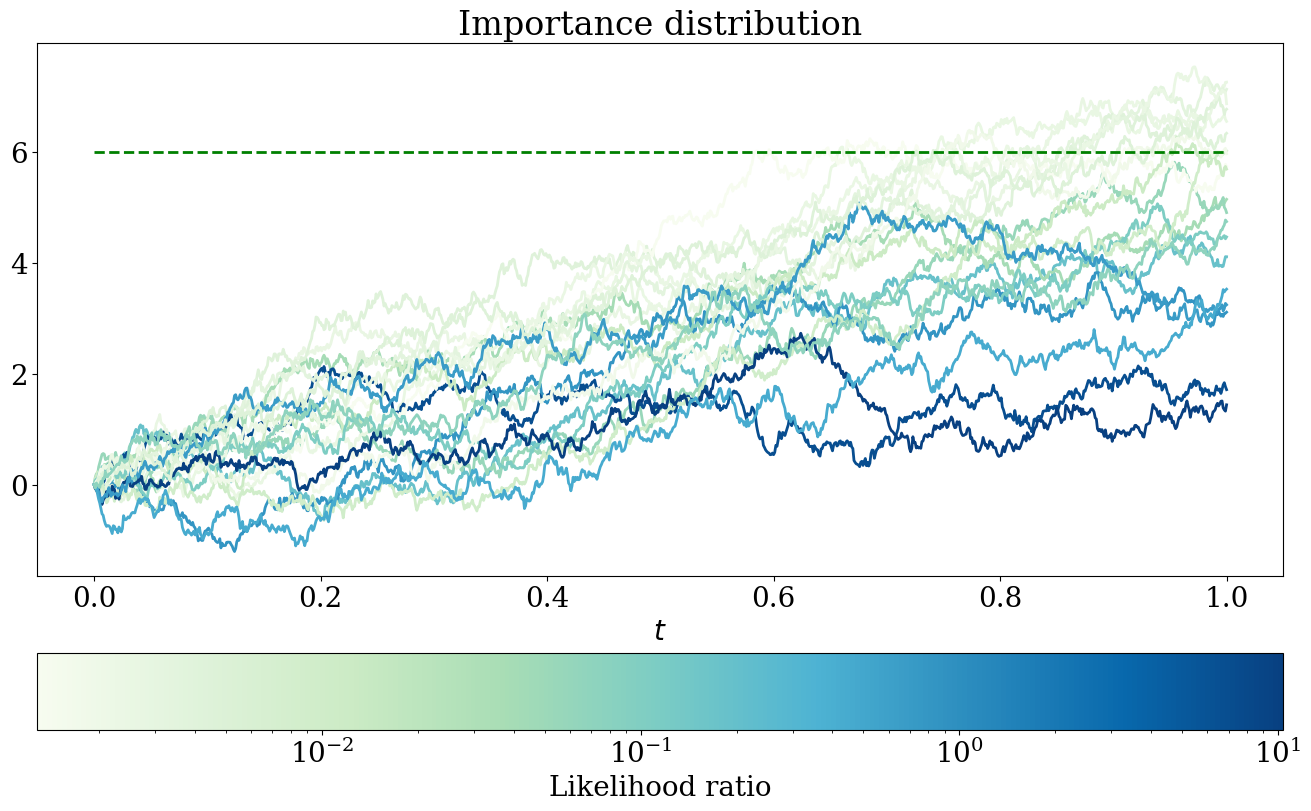

In [5]:
# Parameters
x0, T, sigma, K = 0, 1, 2, 6

# Exact value of probability
P = 2 * (1 - scipy.stats.norm.cdf((K - x0)/(sigma*np.sqrt(T))))

# Indicator functions of which we want to calculate the expectation
def f(x):
    return (np.max(x, axis=0) >= K)*1.

def importance_sampling(b_fun, m, N, plot=False, plot_title=None):
    # N is the number of discretization points and m is the number of samples.

    # Time and Brownian increments
    Δt = T/N
    Δw = np.sqrt(Δt) * np.random.randn(N, m)

    # Likelihood ratio
    def g(x):
        n_paths = x.shape[1]
        result = np.zeros(n_paths)
        for i in range(N):
            bi = b_fun(x[i, :])
            result += bi * (x[i + 1, :] - x[i, :]) - (1/2) * bi**2 * Δt
        return np.exp(-(1/sigma**2) * result)

    # We store the initial condition in x too (hence N + 1)
    x = np.zeros((N + 1, m))

    # Set initial condition
    x[0, :] = x0

    for j in range(N):
        x[j + 1] = x[j] + b_fun(x[j]) * Δt + sigma * Δw[j]

    # Evaluate target function and likelihood ratio
    fx, gx = f(x), g(x)

    estimator = np.mean(fx*gx)
    variance = np.var(fx*gx)

    if plot:
        n_samples = 20

        # Calculate colors
        colors = np.log10(gx[:n_samples])
        Max, Min = np.max(colors), np.min(colors)
        delta = Max - Min

        # Colormap
        cmap = matplotlib.colormaps['GnBu']
        colors = (colors - np.min(colors)) / delta if delta > 1e-8 else None

        # Figure
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(8, 1)

        if delta < 1e-8:
            ax_plot = fig.add_subplot(gs[:, :])
        else:
            ax_plot = fig.add_subplot(gs[:-1, :])
            ax_cb = fig.add_subplot(gs[-1, :])

        t = np.linspace(0, T, N + 1)
        for j in range(n_samples):
            color = cmap(colors[j]) if colors is not None else None
            ax_plot.plot(t, x[:, j], color=color)

        # 'ls' is 'linestyle' and 'c' = 'color'
        ax_plot.plot(t, K + np.zeros(N + 1), ls='--', c='g')
        ax_plot.set_xlabel("$t$")
        ax_plot.set_title(plot_title)

        # Add standalone colorbar
        if delta > 1e-8:
            norm = matplotlib.colors.LogNorm(vmin=10**Min, vmax=10**Max)
            # norm = matplotlib.colors.Normalize(vmin=Min, vmax=Max)
            cb = matplotlib.colorbar.ColorbarBase(
                    ax_cb, cmap=cmap, norm=norm, orientation='horizontal')
            cb.set_label("Likelihood ratio")

        plt.show()

    return estimator, variance


def print_confidence(m, v):
    a = scipy.stats.norm.ppf(.975)
    print("95% confidence interval for P: [{:0.6f}, {:0.6f}]"
            .format(m - a*np.sqrt(v), m + a*np.sqrt(v)))

# Number of samples
m = 10**4

# Default parameter
b = K/T

# Print exact value
print("Exact value of the probability: {0:0.06f}".format(P))

def estimate(N):
    # Without importance sampling
    mean, var = importance_sampling(b_fun=lambda x: 0, m=m, N=N)
    print_confidence(mean, var/m)

    # With importance sampling
    mean_im, var = importance_sampling(b_fun=lambda x: (x < K)*b, m=m, N=N)
    print_confidence(mean_im, var/m)

# Here the error induced by the fact that we are calculating the supremum based
# on only a finite number of discretization points dominates.
estimate(10)
# -

# +
# To obtain a better estimate, we reduce the time step
estimate(10**2)
# -

# +
# We obtain an even better estimate by further reducing the time step
estimate(10**3)
# -

# +
# Plot trajectories from nominal and importance distributions
mean, var = importance_sampling(b_fun=lambda x: 0, m=m, N=10**3, plot=True,
                                plot_title="Nominal distribution")
mean_im, var = importance_sampling(b_fun=lambda x: (x < K)*b, m=m, N=10**3, plot=True,
                                   plot_title="Importance distribution")